In [1]:
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import NearestNeighbors
import pickle
import random
import math
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDRegressor
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.svm import SVR, SVC
from sklearn.metrics import classification_report
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
random.seed(3214)

In [3]:
with open('../data/pickles/main_dict.pickle', 'rb') as f:
    main_dict = pickle.load(f)

In [4]:
df_train = pd.read_csv('../data/csv/train_2.csv', index_col=0)
df_test = pd.read_csv('../data/csv/test_2.csv', index_col=0)

In [5]:
df_train = df_train.drop(df_train.columns[1:553], axis=1)
df_test = df_test.drop(df_test.columns[1:553], axis=1)

In [6]:
features_train = df_train.drop(['file'], 1)
features_test = df_test.drop(['file'], 1)

In [7]:
scaler = StandardScaler()
scaler.fit(features_train)
X_train = scaler.transform(features_train)
X_test = scaler.transform(features_test)

In [8]:
# pca = PCA(0.95)
# pca.fit(X_train)
# X_train = pca.transform(X_train)
# X_test = pca.transform(X_test)

In [9]:
X_train.shape

(7882, 77)

In [10]:
X_test.shape

(100, 77)

In [11]:
with open('../data/tags_similarity.txt', 'r') as f:
    data = f.readlines()

In [12]:
len(data)

34116

In [13]:
all_similarity = [x.strip('\n').split() for x in data]

In [14]:
sc = [float(x[2]) for x in all_similarity]

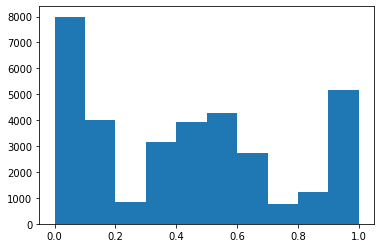

In [15]:
plt.hist(sc, bins=10)
plt.show()

In [16]:
df_train_2 = df_train.reset_index(drop=True)
df_train_2

,file,average_loudness,dynamic_complexity,beats_count,bpm,onset_rate,danceability,chords_changes,chords_number,mfcc1_mean.8,...,pitch_salience.min.8,pitch_salience.std.8,chords.max.8,chords.mean.8,chords.min.8,chords.std.8,hpcp.max.8,hpcp.mean.8,hpcp.min.8,hpcp.std.8
0,113360.mp3,0.735970,5.961013,57,110.600258,2.767721,1.203128,0.085008,0.020093,-858.344360,...,0.104731,0.131907,0.839291,0.532144,0.258613,0.124811,35.831059,14.959072,3.070178,7.288480
1,113564.mp3,0.968318,1.603451,61,124.743881,5.735518,1.081261,0.088099,0.026275,-667.543823,...,0.259244,0.097776,0.691749,0.467287,0.207034,0.111577,35.785088,13.921927,2.618005,6.847598
2,113950.mp3,0.866255,5.594617,72,147.022476,3.601372,0.990250,0.034003,0.010819,-810.841736,...,0.112524,0.130163,0.770893,0.615786,0.365535,0.079525,35.804550,15.433070,2.676239,7.629828
3,113267.mp3,0.978087,1.169995,79,161.498962,3.267912,1.071076,0.047913,0.010819,-618.257324,...,0.273620,0.119000,0.741139,0.547176,0.267749,0.099131,35.739342,10.841406,2.722672,5.521516
4,113261.mp3,0.958599,2.754046,44,90.023399,4.601753,1.261835,0.151468,0.024730,-656.268799,...,0.136364,0.138839,0.663160,0.460699,0.237102,0.089502,35.844589,11.433019,3.062327,5.329480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7877,029040.mp3,0.601901,4.741628,46,94.569443,4.835176,1.093997,0.075734,0.015456,-746.406067,...,0.037965,0.156953,0.627632,0.452549,0.259658,0.089888,35.813511,13.423307,3.492393,6.177996
7878,029255.mp3,0.651028,5.826573,80,178.205734,3.197506,0.835034,0.084877,0.018519,-733.472656,...,0.140011,0.139329,0.697704,0.469045,0.260135,0.084404,35.851913,16.614149,0.000000,10.594819
7879,029526.mp3,0.957812,2.884877,64,129.861832,3.201220,1.139050,0.063369,0.009274,-659.415771,...,0.225821,0.115231,0.569408,0.446405,0.227650,0.060741,35.851040,20.483692,4.004978,8.654058
7880,029245.mp3,0.969260,2.810955,69,140.128616,3.630502,1.424422,0.067901,0.013889,-651.825989,...,0.287203,0.092962,0.747907,0.542799,0.222208,0.104758,35.841602,13.581528,3.772308,6.252968


In [17]:
features = list()
target = list()
for tupple in all_similarity:
    idx_1 = df_train_2[df_train_2.file == tupple[0]].index[0]
    idx_2 = df_train_2[df_train_2.file == tupple[1]].index[0]
    arr_1 = X_train[idx_1]
    arr_2 = X_train[idx_2]
    combo = np.hstack((arr_1, arr_2))
    features.append(combo)
    target.append(float(tupple[2]))

In [18]:
features_train, features_test, target_train, target_test = train_test_split(
    features,
    target,
    random_state=123
)

In [19]:
lgbm = LGBMRegressor(num_iteration=10000, max_depth=5, reg_lambda=0.8, reg_alpha=0.6)
lgbm.fit(features_train, target_train)
y_pred_train = lgbm.predict(features_train)
y_pred_test = lgbm.predict(features_test)
rmse_train = mean_squared_error(target_train, y_pred_train)
rmse_test = mean_squared_error(target_test, y_pred_test)
r2_train = r2_score(target_train, y_pred_train)
r2_test = r2_score(target_test, y_pred_test)
print(f'rmse {rmse_train}/{rmse_test} r2 {r2_train}/{r2_test}')

/home/obi-1-konobe/projects/mag/dp/dp_project/venv/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


rmse 0.0005161095370617439/0.056882255501221696 r2 0.9952258669407895/0.46755556886556804


In [20]:
cos_similarity_mtx = cosine_similarity(X_test, X_train)

In [21]:
def count_good_recommend(query_idx, answer_list, trhold):
    counter = 0
    query_id = int(df_test.iloc[query_idx].file[:-4])
    relevant = [query_id]
    query_tags = main_dict[query_id]['all_tags']
    for idx in answer_list:
        answer_id = int(df_train.iloc[idx].file[:-4])
        answer_tags = main_dict[answer_id]['all_tags']
        score = 0
        i = 0
        for tag in answer_tags:
            if tag in query_tags:
                i += 1
        if i == 0:
            continue
        
        precision = i / len(answer_tags)
        recall = i / len(query_tags)
        score = 2 * precision * recall / (precision + recall)
        if score >= trhold:        
            counter += 1
            relevant.append(answer_id)
    return counter, relevant

In [22]:
def count_ndcg(neighbors, relevant_list):
    dcg = 0
    idcg = 0
    for i in range(len(neighbors)):
        track = int(df_train.iloc[neighbors[i]].file[:-4])
        if track in relevant_list:
            dcg += 1 / math.log(i + 2, 2)
        idcg += 1 / math.log(i + 2, 2)
    ndcg = dcg / idcg
    return ndcg

In [23]:
def rank_by_model(model, neighb, arr_test):
    result = list()
    for idx in neighb:
        arr_2 = X_train[idx]
        combo = np.hstack((arr_test, arr_2))
        score = model.predict([combo])
        result.append((idx, score))
    top_10 = sorted(result, key=lambda x: x[1], reverse=True)[:10]
    top_10 = [x[0] for x in top_10]

    return top_10

In [24]:
mean_ap = 0
ndcg = 0
for i in range(100):
    arr = cos_similarity_mtx[i]
    neighbors = arr.argsort()[-100:][::-1]
    level_2 = rank_by_model(lgbm, neighbors, X_test[i])
    relevant_num, relevant_list = count_good_recommend(i, level_2, trhold=0.4)
#     print(relevant_list)
#     print(relevant_list[0], [df_train.iloc[x].file[:-4] for x in level_2])
    p_at_10 = relevant_num / 10
    mean_ap += p_at_10
    ndcg += count_ndcg(level_2, relevant_list[1:])
mean_ap /= 100 
mean_ndcg = ndcg / 100
print(mean_ap, mean_ndcg)

0.12399999999999994 0.13702756544131903


In [35]:
from lightgbm import plot_importance
import seaborn as sns

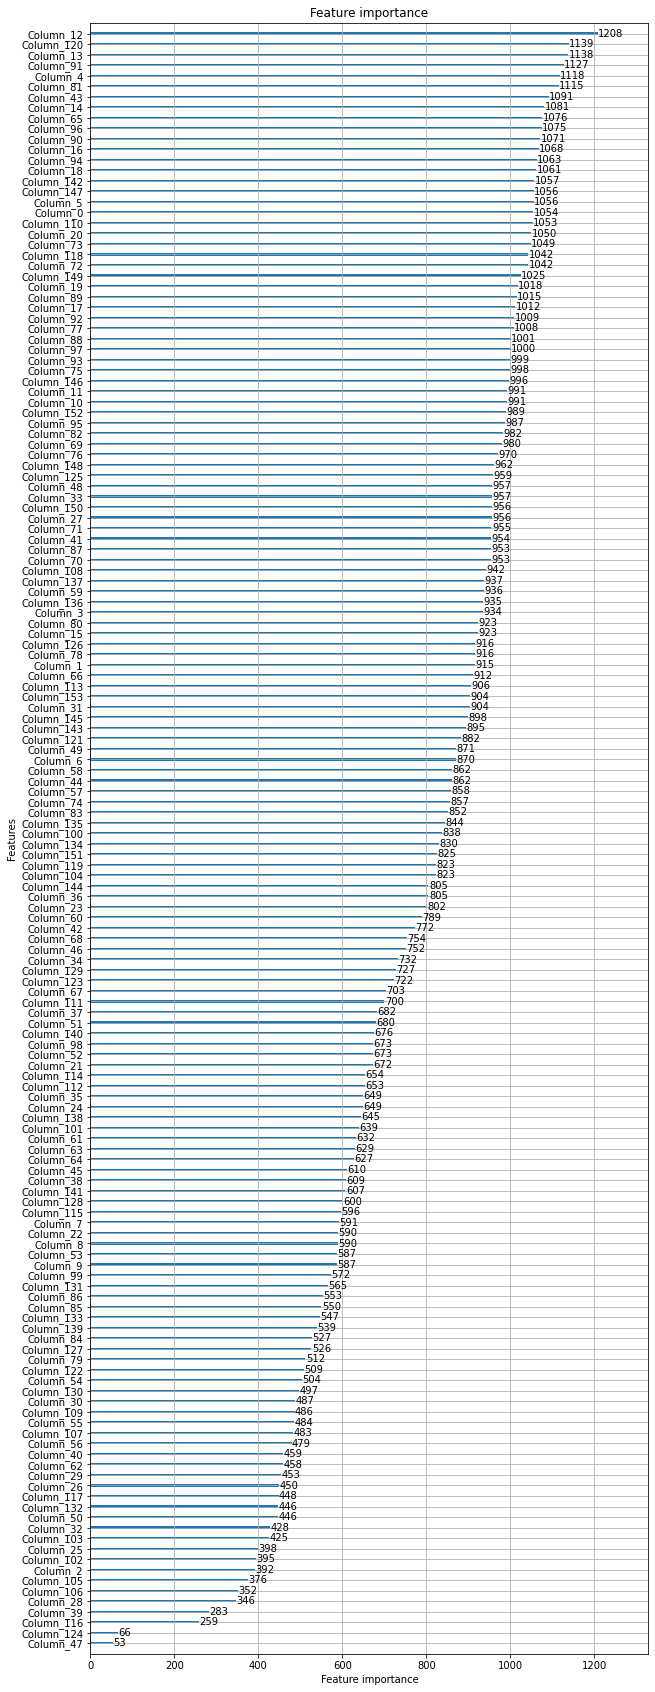

In [33]:
plot_importance(lgbm, figsize=(10,30), importance_type='split')

In [34]:
def plotImp(model, X , num = 20):
    feature_imp = pd.DataFrame({'Value':model.feature_importance(),'Feature':X.columns})
    plt.figure(figsize=(40, 20))
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
#     plt.savefig('lgbm_importances-01.png')
    plt.show()

In [42]:
imp = pd.concat([df_train.drop(columns=['file']), df_train.drop(columns=['file'])])
imp

,average_loudness,dynamic_complexity,beats_count,bpm,onset_rate,danceability,chords_changes,chords_number,mfcc1_mean.8,mfcc2_mean.8,...,pitch_salience.min.8,pitch_salience.std.8,chords.max.8,chords.mean.8,chords.min.8,chords.std.8,hpcp.max.8,hpcp.mean.8,hpcp.min.8,hpcp.std.8
0,0.735970,5.961013,57,110.600258,2.767721,1.203128,0.085008,0.020093,-858.344360,210.550842,...,0.104731,0.131907,0.839291,0.532144,0.258613,0.124811,35.831059,14.959072,3.070178,7.288480
1,0.968318,1.603451,61,124.743881,5.735518,1.081261,0.088099,0.026275,-667.543823,155.661987,...,0.259244,0.097776,0.691749,0.467287,0.207034,0.111577,35.785088,13.921927,2.618005,6.847598
2,0.866255,5.594617,72,147.022476,3.601372,0.990250,0.034003,0.010819,-810.841736,175.682144,...,0.112524,0.130163,0.770893,0.615786,0.365535,0.079525,35.804550,15.433070,2.676239,7.629828
3,0.978087,1.169995,79,161.498962,3.267912,1.071076,0.047913,0.010819,-618.257324,151.434280,...,0.273620,0.119000,0.741139,0.547176,0.267749,0.099131,35.739342,10.841406,2.722672,5.521516
4,0.958599,2.754046,44,90.023399,4.601753,1.261835,0.151468,0.024730,-656.268799,99.321548,...,0.136364,0.138839,0.663160,0.460699,0.237102,0.089502,35.844589,11.433019,3.062327,5.329480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7981,0.601901,4.741628,46,94.569443,4.835176,1.093997,0.075734,0.015456,-746.406067,145.601059,...,0.037965,0.156953,0.627632,0.452549,0.259658,0.089888,35.813511,13.423307,3.492393,6.177996
7982,0.651028,5.826573,80,178.205734,3.197506,0.835034,0.084877,0.018519,-733.472656,152.343552,...,0.140011,0.139329,0.697704,0.469045,0.260135,0.084404,35.851913,16.614149,0.000000,10.594819
7983,0.957812,2.884877,64,129.861832,3.201220,1.139050,0.063369,0.009274,-659.415771,76.092545,...,0.225821,0.115231,0.569408,0.446405,0.227650,0.060741,35.851040,20.483692,4.004978,8.654058
7984,0.969260,2.810955,69,140.128616,3.630502,1.424422,0.067901,0.013889,-651.825989,132.384949,...,0.287203,0.092962,0.747907,0.542799,0.222208,0.104758,35.841602,13.581528,3.772308,6.252968


In [79]:
with_similar = list()
for idx in main_dict:
    if len(main_dict[idx]['similar_list']) > 0:
        with_similar.append(idx)

In [87]:
features = list()
target = list()
for idx in with_similar:
    track_1 = "{:06d}".format(idx) + '.mp3'
    if track_1 in df_train_2.file.values:
        id_1 = df_train_2[df_train_2.file == track_1].index[0]
        arr_1 = X_train[id_1]
        for pair in main_dict[idx]['similar_list']:
            artist, title, _ = pair
            for idx_2 in main_dict:
                if main_dict[idx_2]['artist_name'] == artist and main_dict[idx_2]['track_title'] == title:
                    track_2 = "{:06d}".format(idx_2) + '.mp3'
                    if track_2 in df_train_2.file.values:
                        id_2 = df_train_2[df_train_2.file == track_2].index[0]
                        arr_2 = X_train[id_2]
                        combo = np.hstack((arr_1, arr_2))
                        features.append(combo)
                        target.append(1)
                        break

In [88]:
len(target)

1898

In [90]:
while len(features) < 1898 * 2:
    pair = random.sample(list(df_train_2.file.values), 2)
    id_1 = int(pair[0][:-4])
    id_2 = int(pair[1][:-4])
    if len(set(main_dict[id_1]['all_genres']) & set(main_dict[id_2]['all_genres'])) == 0:
        idx_1 = df_train_2[df_train_2.file == pair[0]].index[0]
        idx_2 = df_train_2[df_train_2.file == pair[1]].index[0]
        arr_1 = X_train[idx_1]
        arr_2 = X_train[idx_2]
        combo = np.hstack((arr_1, arr_2))
        features.append(combo)
        target.append(0) 

In [91]:
len(features)

3796

In [92]:
features_train, features_test, target_train, target_test = train_test_split(
    features,
    target,
    test_size=0.1, 
    random_state=123
)

In [93]:
lgbm_c = LGBMClassifier(num_iteration=10000, max_depth=5, reg_lambda=0.8, reg_alpha=0.6)

In [94]:
lgbm_c.fit(features_train, target_train)

/home/obi-1-konobe/projects/mag/dp/dp_project/venv/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=5,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_iteration=10000, num_leaves=31,
               objective=None, random_state=None, reg_alpha=0.6, reg_lambda=0.8,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [100]:
target_pred = lgbm_c.predict(features_test)
# target_pred[:,1]

In [101]:
target_train_pred = lgbm_c.predict(features_train)

In [102]:
print(classification_report(target_test, target_pred))

              precision    recall  f1-score   support

           0       0.86      0.80      0.83       197
           1       0.80      0.86      0.83       183

    accuracy                           0.83       380
   macro avg       0.83      0.83      0.83       380
weighted avg       0.83      0.83      0.83       380



In [107]:
def count_good_recommend(query_idx, answer_list, trhold):
    counter = 0
    query_id = int(df_test.iloc[query_idx].file[:-4])
    relevant = [query_id]
    query_tags = main_dict[query_id]['all_tags']
    for idx in answer_list:
        answer_id = int(df_train.iloc[idx].file[:-4])
        answer_tags = main_dict[answer_id]['all_tags']
        score = 0
        i = 0
        for tag in answer_tags:
            if tag in query_tags:
                i += 1
        if i == 0:
            continue
        
        precision = i / len(answer_tags)
        recall = i / len(query_tags)
        score = 2 * precision * recall / (precision + recall)
        if score >= trhold:        
            counter += 1
            relevant.append(answer_id)
    return counter, relevant

In [108]:
def count_ndcg(neighbors, relevant_list):
    dcg = 0
    idcg = 0
    for i in range(len(neighbors)):
        track = int(df_train.iloc[neighbors[i]].file[:-4])
        if track in relevant_list:
            dcg += 1 / math.log(i + 2, 2)
        idcg += 1 / math.log(i + 2, 2)
    ndcg = dcg / idcg
    return ndcg

In [109]:
def rank_by_model(model, neighb, arr_test):
    result = list()
    for idx in neighb:
        arr_2 = X_train[idx]
        combo = np.hstack((arr_test, arr_2))
        score = model.predict_proba([combo])[:,1]
        result.append((idx, score))
    top_10 = sorted(result, key=lambda x: x[1], reverse=True)[:10]
    top_10 = [x[0] for x in top_10]

    return top_10

In [110]:
mean_ap = 0
ndcg = 0
for i in range(100):
    arr = cos_similarity_mtx[i]
    neighbors = arr.argsort()[-100:][::-1]
    level_2 = rank_by_model(lgbm_c, neighbors, X_test[i])
    relevant_num, relevant_list = count_good_recommend(i, level_2, trhold=0.3)
#     print(relevant_list)
#     print(relevant_list[0], [df_train.iloc[x].track[:-4] for x in level_2])
    p_at_10 = relevant_num / 10
    mean_ap += p_at_10
    ndcg += count_ndcg(level_2, relevant_list[1:])
mean_ap /= 100 
mean_ndcg = ndcg / 100

In [111]:
mean_ap

0.11899999999999988

In [112]:
mean_ndcg

0.11627015309857963

In [300]:
cos_similarity_mtx = cosine_similarity(X_test, X_train)

In [301]:
mean_ap = 0
ndcg = 0
for i in range(100):
    arr = cos_similarity_mtx[i]
    neighbors = arr.argsort()[-100:][::-1]
    level_2 = rank_by_model(lgbm, neighbors, X_test[i])
    relevant_num, relevant_list = count_good_recommend(i, level_2, trhold=0.3)
#     relevant_num, relevant_list = count_good_recommend(i, neighbors, trhold=0.4)
#     print(relevant_list)
    print(relevant_list[0], [df_train.iloc[x].track[:-4] for x in level_2])
    p_at_10 = relevant_num / 10
    mean_ap += p_at_10
    ndcg += count_ndcg(neighbors, relevant_list[1:])
mean_ap /= 100 
mean_ndcg = ndcg / 100

10673 ['028477', '102195', '106953', '085816', '028485', '111378', '069791', '028482', '047707', '111397']
66643 ['092949', '051269', '067237', '098077', '138041', '013556', '091084', '091468', '142577', '036322']
194 ['143218', '032800', '097587', '127870', '120309', '016747', '053576', '016744', '087189', '105915']
74421 ['004080', '142528', '020704', '072058', '148214', '104009', '101112', '148215', '056520', '085291']
131553 ['023013', '114201', '123835', '144173', '087644', '021404', '040842', '013571', '055827', '086634']
24431 ['097961', '051111', '056695', '070655', '052035', '115475', '036961', '126516', '131326', '051260']
144469 ['075432', '012486', '052954', '091897', '006407', '006406', '077519', '110927', '114396', '127192']
87100 ['093364', '010439', '075607', '010440', '010385', '123488', '116451', '133449', '051776', '057628']
69204 ['044821', '075378', '070654', '084096', '070770', '141593', '070768', '139937', '035549', '110771']
27454 ['080004', '040239', '075442', 

73365 ['110690', '092574', '086039', '085836', '013708', '049473', '004521', '052449', '055186', '081576']
5264 ['112065', '021404', '075379', '055285', '098555', '126047', '099260', '087237', '060994', '098551']
19759 ['040239', '085836', '038781', '075194', '149103', '057819', '100497', '154413', '124912', '029720']
41568 ['056519', '097589', '083440', '115176', '049849', '129188', '126283', '116871', '145476', '056797']
24429 ['110690', '069822', '053591', '133452', '040239', '035549', '124870', '048864', '122628', '045392']
86788 ['108502', '040986', '058542', '087152', '064006', '112314', '021895', '096935', '054624', '054626']
152418 ['069764', '040235', '122398', '009918', '038817', '040232', '014590', '004836', '038776', '084158']
64630 ['140939', '011922', '054470', '073768', '114061', '026008', '043857', '071231', '107129', '025605']
85832 ['110690', '075442', '069791', '085836', '092546', '087185', '080001', '046024', '052449', '116116']
75317 ['075379', '098556', '129887', 

In [291]:
mean_ap

0.12099999999999995

In [292]:
mean_ndcg

0.013384470428357782

[6645, 4701, 7183, 3518, 4410, 7236, 3979, 1258, 7490, 7097]

In [304]:
a = lgbm.predict_proba(X_train)

ValueError: Number of features of the model must match the input. Model n_features_ is 206 and input n_features is 103 

87097 ['081660', '132566', '108024', '108022', '133970', '024217', '108017', '061007', '132448', '142098']

87097 ['126559', '087103', '108885', '087101', '126321', '121987', '142098', '125657', '108024', '086481']

87097 ['111222', '087103', '086486', '133561', '065038', '064994', '028274', '077522', '087099', '098237']

87097 ['111222', '087103', '086486', '081803', '133561', '065038', '133580', '116101', '084201', '126557']

In [103]:
df_test_2 = df_test.reset_index(drop=True)


In [302]:
track_1 = '087097.mp3'
track_2 = '126557.mp3'

In [303]:
idx_1 = df_test_2[df_test_2.track == track_1].index[0]
idx_2 = df_train_2[df_train_2.track == track_2].index[0]
arr_1 = X_test[idx_1]
arr_2 = X_train[idx_2]
combo = np.hstack((arr_1, arr_2))
lgbm.predict_proba([combo])[:,1]

array([0.37847317])

In [176]:
tags_1 = main_dict[int(track_1[:-4])]['all_tags']
tags_2 = main_dict[int(track_2[:-4])]['all_tags']
intersection = set(tags_1) & set(tags_2)

precision = len(intersection) / len(tags_1)
recall = len(intersection) / len(tags_2)
score = 2 * precision * recall / (precision + recall)
score = round(score, 2)
score

1.0

In [177]:
tags_1

['idm',
 'ambient',
 'electronic',
 'instrumental',
 'chillout',
 'electronica',
 'post-rock',
 'classic',
 'electro',
 'soundtrack']

In [178]:
tags_2

['idm',
 'ambient',
 'electronic',
 'instrumental',
 'chillout',
 'electronica',
 'post-rock',
 'classic',
 'electro',
 'soundtrack']

In [182]:
result = list()
for idx in main_dict:
    if len(main_dict[idx]['similar_list']) > 0:
        result.append(idx)

In [191]:
len(result)

1138

In [211]:
len(set(main_dict[534]['all_genres']) & set(main_dict[540]['all_genres']))

1

In [190]:
main_dict[540]

{'artist_name': 'Charles Manson',
 'track_title': 'The Black Pirate',
 'artist_tags': [('folk', '100'),
  ('singer-songwriter', '58'),
  ('psychedelic', '54'),
  ('experimental', '36'),
  ('misunderstood geniuses', '27'),
  ('acoustic', '20'),
  ('psychedelic folk', '12'),
  ('serial killer', '9'),
  ('american', '8'),
  ('acid folk', '8')],
 'track_tags': [('counter-culture', '100')],
 'similar_tracks': [('Charles Manson', 'Brother Gun', 1.0),
  ('Charles Manson', 'Angels Fear To Tread', 0.82),
  ('Tim Buckley', 'No Man Can Find The War', 0.311),
  ('Jasmina Maschina', 'Love You More & More', 0.012),
  ('Jasmina Maschina', 'Joyrider', 0.012),
  ('Ween', 'Duke of Denim', 0.012),
  ('Damien Youth', 'Bride of the Asylum', 0.011),
  ('Donovan', 'Cosmic Wheels', 0.011),
  ('Damien Youth', 'The Girl With the Serpent Eyes', 0.011),
  ('Damien Youth', 'Fran (Ex Left Banke - The Beckies Cover)', 0.011),
  ('Damien Youth', 'The Telepath (Unreleased Track)', 0.011),
  ('Damien Youth', 'Test Tube

In [189]:
for idx in main_dict:
    if main_dict[idx]['artist_name'] == 'Charles Manson' and main_dict[idx]['track_title'] == 'The Black Pirate':
        print(idx)
        break

540


In [111]:
df_test_2[df_test_2.track == '087097.mp3']

,track,1_mfcc_1,1_mfcc_2,1_mfcc_3,1_mfcc_4,1_mfcc_5,1_mfcc_6,1_mfcc_7,1_mfcc_8,1_mfcc_9,...,all_ss_min,all_ss_std,all_sf_max,all_sf_mean,all_sf_min,all_sf_std,all_zcr_max,all_zcr_mean,all_zcr_min,all_zcr_std
47,087097.mp3,-815.897278,330.361633,-24.059116,-18.602432,20.005129,-4.015804,-11.668517,-7.022644,-0.156837,...,2.436082,2.976102,0.252494,0.05244,0.012415,0.031541,0.037598,0.018503,0.005859,0.005123


In [109]:
df_test_2

,track,1_mfcc_1,1_mfcc_2,1_mfcc_3,1_mfcc_4,1_mfcc_5,1_mfcc_6,1_mfcc_7,1_mfcc_8,1_mfcc_9,...,all_ss_min,all_ss_std,all_sf_max,all_sf_mean,all_sf_min,all_sf_std,all_zcr_max,all_zcr_mean,all_zcr_min,all_zcr_std
0,010673.mp3,-626.681091,132.151154,11.753740,45.711430,-0.209040,10.068515,-0.682384,5.395576,-4.435939,...,0.461337,0.281160,0.329500,0.124018,0.027167,0.045374,0.130859,0.031217,0.003418,0.019365
1,066643.mp3,-687.945374,141.427277,-16.972485,19.092112,6.906140,3.117708,6.967309,-2.045398,-7.208217,...,-0.111801,0.627290,0.380662,0.080697,0.000165,0.061523,0.282227,0.049509,0.002930,0.025951
2,000194.mp3,-782.241943,178.044266,-29.330959,18.219608,-14.123279,-10.458302,-16.387886,-5.279102,-16.686710,...,0.276664,0.634153,0.264619,0.043619,0.000129,0.038136,0.169922,0.037896,0.001953,0.017058
3,074421.mp3,-623.853394,122.672737,17.257471,4.505549,0.719744,-2.922961,-5.741470,-1.727011,-18.558123,...,0.421106,0.539590,0.264868,0.082399,0.007031,0.040712,0.224121,0.051835,0.009277,0.032241
4,131553.mp3,-645.512512,74.718880,12.483846,45.145756,38.911320,16.187067,6.199753,0.013115,-3.431449,...,0.100123,0.391042,0.335317,0.112432,0.000625,0.050604,0.271973,0.079668,0.008789,0.049538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,025603.mp3,-705.887451,168.620865,34.891018,33.937485,15.525203,2.845042,-8.320030,2.128073,10.097413,...,0.422947,1.021024,0.493078,0.113007,0.003961,0.076067,0.147949,0.026009,0.002441,0.020538
96,075417.mp3,-637.247192,73.643715,17.631123,33.222134,11.122272,9.398943,12.663881,11.582001,10.201411,...,0.267713,0.341603,0.467992,0.120776,0.001821,0.087565,0.348633,0.081037,0.009766,0.044586
97,125154.mp3,-694.168884,92.781448,59.304184,42.092861,12.254707,19.374973,4.323670,7.782975,-5.282559,...,-0.067733,0.774724,0.482886,0.110169,0.003097,0.075931,0.317871,0.064865,0.002441,0.054606
98,075436.mp3,-800.051819,241.068558,40.636051,-0.057632,6.397528,-18.648108,-1.818632,3.204657,-0.186070,...,0.923011,1.546881,1.210505,0.112725,0.010022,0.145565,0.138184,0.015291,0.000488,0.012997


In [84]:
df_train[df_train.track == '081512.mp3'].drop(columns=['track']).values

array([[-7.74647705e+02,  1.26531204e+02,  1.43112164e+01,
         1.14453869e+01, -8.95931244e+00, -9.55889320e+00,
        -1.35218897e+01,  2.28147745e+00,  1.78788033e+01,
         7.60553885e+00,  6.46068764e+00,  5.74957466e+00,
         2.95985079e+00,  4.32843555e+03,  1.02788281e+03,
         1.08554832e+02,  9.14352112e+02,  1.19996819e+02,
         1.40324879e+01, -1.35242832e+00,  1.88848228e+01,
         1.13695312e+04,  1.68837732e+03,  8.61328125e+01,
         2.64714722e+03,  9.10147858e+00,  2.54628015e+00,
         4.16384824e-02,  1.58443892e+00,  3.64557415e-01,
         7.18303695e-02,  6.19487313e-04,  7.85310268e-02,
         3.59863281e-01,  5.66855259e-02,  2.44140625e-03,
         6.01763166e-02, -8.02175903e+02,  1.36923691e+02,
         2.09778728e+01,  2.03402443e+01,  2.40463424e+00,
         6.60363150e+00,  4.70998526e+00,  1.70874729e+01,
         2.93335152e+01,  1.52756615e+01,  3.09140229e+00,
        -4.18995047e+00, -4.08248231e-03,  3.83288086e+0

In [39]:
a = main_dict[84096]['all_tags']
b = main_dict[136994]['all_tags']
set(a) & set(a)

{'abstract',
 'abstract hip hop',
 'braindance',
 'breakbeat',
 'breakcore',
 'drum & bass',
 'dubstep',
 'electronic',
 'electronica',
 'glitch',
 'idm',
 'under 2000 listeners'}